This notebook evaluates the performance of just parallelizing the similarity over CPUs (**not GPUs**).

In [1]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'ALL_GNPS.pickle'

# We take a random sample of spectra from said file

# Minimum size:
chunk_sizes_min = 32

# Maximum size
chunk_sizes_max = 4096

# how many points to evaluate (in logspace) between min and max
num_evals = 15

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
max_peaks = 1024

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 2048

# In this case we won't use the GPU, but we still print it here
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-36f6d0f7-d34d-ba22-e10a-d8e3a8fbc5ff)
Number of CPU cores 32


In [2]:
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

In [8]:
from cudams.utils import argbatch, Timer
from cudams.similarity.spectrum_similarity_functions import cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
import pickle
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf

spectra = pickle.load(open(download(spectra_file),'rb'))

/opt/conda/lib/python3.10/site-packages/cudams/utils.py:243: UserWarning: As of 2024, ALL_GNPS.pickle is a large file (1.76GB) make sure the machine can handle this
  warnings.warn(f"As of 2024, {name} is a large file (1.76GB) make sure the machine can handle this")
100%|█████████████████████████████████████| 1.47G/1.47G [00:00<00:00, 1.58TB/s]
SHA256 hash of downloaded file: 473593b86b35de9bc90c216b70ca7f64628bf577cb4bc64afd1d4d0a533ab1f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [ ]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from cudams.utils import Timer

np.random.seed(42)
chunk_sizes = np.round(np.logspace(
    np.log2(chunk_sizes_min), 
    np.log2(chunk_sizes_max), 
    num=num_evals, 
    base=2, 
    endpoint=True)
).astype(int)

times = []
pairs = []
kernel = CosineGreedy()

def loop(chunk_size):
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = references
    with Timer() as timer:
        kernel.matrix(references, queries, is_symmetric=True)
    return timer.duration, len(references) * len(queries) / 2 # Div by 2 because it's symmetric

# Do it in parallel, each experiment gets own CPU, so comparison is still fair.
data = Parallel(-1)(delayed(loop)(chunk_size) for chunk_size in tqdm(chunk_sizes))
times, pairs = zip(*data)

100%|██████████| 15/15 [00:00<00:00, 30.42it/s]


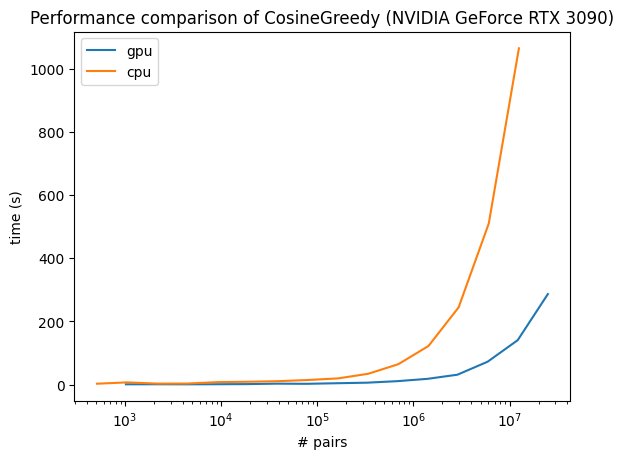

In [9]:
plt.semilogx(pairs, times, label='signle_cpu')
plt.title(f"Performance comparison of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

In [11]:
import json

benchmark_summary = dict(
        pairs=pairs,
        times=times,
        pairs_cu=pairs_cu,
        times_cu=times_cu,
        device=torch.cuda.get_device_name(),
        nproc=os.cpu_count(),    
    )
print(json.dumps(benchmark_summary,indent=1))

{
 "pairs": [
  512.0,
  1058.0,
  2178.0,
  4418.0,
  9248.0,
  18818.0,
  38920.5,
  80000.0,
  164738.0,
  338664.5,
  697380.5,
  1434818.0,
  2952450.0,
  6076098.0,
  12500000.0
 ],
 "times": [
  2.510380507912487,
  6.7423988110385835,
  2.8259035730734468,
  2.9969306709244847,
  7.5640333781484514,
  8.661761027062312,
  10.51795136090368,
  14.238328704843298,
  19.355696046026424,
  33.92394217592664,
  64.3785207408946,
  121.92021065205336,
  244.2252360819839,
  509.77346571790986,
  1064.0906087688636
 ],
 "pairs_cu": [
  1024,
  2116,
  4356,
  8836,
  18496,
  37636,
  77841,
  160000,
  329476,
  677329,
  1394761,
  2869636,
  5904900,
  12152196,
  25000000
 ],
 "times_cu": [
  0.6104052199516445,
  0.789918142138049,
  0.5713207859080285,
  0.8430667349603027,
  1.2284796710591763,
  2.680373721057549,
  2.1905022931750864,
  4.024061013944447,
  5.755711151054129,
  10.548923182068393,
  17.852711874060333,
  31.034789178986102,
  72.08815707708709,
  140.39181540